# Описание проекта
## Необходимо найти инсайты в данных продуктовых магазинов компании. 
### На повестке 3 задачи:
 1. Выяснить, какие пары товаров пользователи чаще всего покупают вместе. По сути, необходимо найти паттерны покупок, что позволит оптимизировать размещение продуктов в магазине, для удобства пользователей и увеличения выручки. Нужно указать 5 наиболее распространённых паттернов.
    В файле содержится информация о покупках людей:
     - id – означает покупку (в одну покупку входят все товары, купленные пользователем во время 1 похода в магазин)
     - Товар – наименование товара
     - Количество – число единиц купленного товара
     
 
 2. Поступила информация о числе заказов за прошедшие 3 месяца с разрешением по неделям. Построить (если это возможно) прогноз продаж на следующие 3 месяца, с учётом того, что в неделю с 2020-02-02 по 2020-02-09 была проведена массивная акция, повысившая число заказов на 7%.


3. В базе данных компании присутствуют следующие таблицы:

  - city
      - city_id – id города, где проходит акция
      - client_city_id – id города, где находится покупатель
      - city – город
      - client_city – город, где находится покупатель
  - client
      - client_id – id покупателя
      - client_city_id – id города, где находится покупатель
      - birth_date – дата рождения покупателя
      - registration – дата регистрации покупателя
  - promotion
      - promotion_id – id акции
      - category_id – id категории
      - promotion_name – акция
      - category_name – категория
      - partner_id – id партнёра
      - partner_name – партнёр
  - purchase
      - purchase_id – id покупки
      - partner_id – id партнёра
      - client_id – id покупателя
      - city_id – id города
      - promotion_id – id акции
      - category_id – id категории
      - purchase_date – дата покупки
      - price – цена за единицу товара
      - quantity – число проданных единиц
      - status – статус покупки
      
      
Нужно написать запрос, чтобы получить такую таблицу
  - purchase_date – дата покупки
  - purchase_id – id покупки
  - client_id – id покупателя
  - client_age – возраст покупателя
  - client_registration_age – как долго человек пользуется вашими магазинами
  - client_category – содержит new или old, если это первая или последующая покупка соответственно
  - promotion_name – акция
  - category_name – категория
  - partner_name – партнёр
  - client_city – город, где находится покупатель
  - city – город
  - revenue – сумма выручки
  - quantity – число проданных единиц

При этом в таблице должны присутствовать только значения, где в поле status стоит значение 1, и только те, где purchase_date находится в диапазоне от 01.05.2020 до 01.08.2020

   База данных доступна по имени project_variant_2  

### Импортируем библиотеки

In [71]:
import pandas as pd
from itertools import combinations
# Для Графиков
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm

### Изучим данные

In [72]:
df = pd.read_csv('test1_completed.csv')

In [73]:
df.head()

,id,Товар,Количество
0,17119,Лимон,1.1
1,17119,Лимон оранжевый,0.7
2,17119,Лук-порей,10.0
3,17119,Лук репчатый,2.5
4,17119,Малина свежая,1.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43514 entries, 0 to 43513
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          43514 non-null  int64  
 1   Товар       43514 non-null  object 
 2   Количество  43514 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1020.0+ KB


In [5]:
# Постомтрим основные метрики категориальных данных
df.describe(include=['object'])

,Товар
count,43514
unique,199
top,Огурцы Луховицкие
freq,1022


In [6]:
# проверим пропуски
df.isnull().sum()

id            0
Товар         0
Количество    0
dtype: int64

In [74]:
# переименуем столбцы для более убдобного к ним обращения
df.rename(columns={'Товар': 'products', 'Количество': 'quantity'}, inplace=True)

In [75]:
df.head()

,id,products,quantity
0,17119,Лимон,1.1
1,17119,Лимон оранжевый,0.7
2,17119,Лук-порей,10.0
3,17119,Лук репчатый,2.5
4,17119,Малина свежая,1.0


### Задание 1.
Посчитаем чаще всего встречающиеся в одном заказе пары товаров

In [76]:
# создадим список всех товаров
products_unique = list(df['products'].unique()) 

In [67]:
# создадим список всех возможных пар товаров
product_pairs = list(combinations(products_unique, 2))

In [77]:
# составим список заказов, в которых был куплен только один товар
one_product_purchase = df.groupby('id', as_index=False).agg({'products': 'count'}).query('products == 1').id.values 

In [78]:
# список покупок без учета заказов с покупкой только одного товара
purchases_products = df.query('id not in @one_product_purchase').groupby('id', as_index=False)\
.agg({'products': 'unique'})

In [79]:
purchases_products.head()

,id,products
0,17119,"[Лимон, Лимон оранжевый, Лук-порей, Лук репчат..."
1,17530,"[Лимон оранжевый, Изюм Султана, Капуста цветна..."
2,17618,"[Абрикосы молдавские, Кукуруза мини, Грибы лис..."
3,17724,"[Абрикосы молдавские, Арбуз, Салат Айсберг, Га..."
4,17814,"[Арбуз, Кабачки, Кинза, Малина свежая, Морковь..."


In [80]:
# создадим новый датафрейм с парами товаров в заказах
df_1 = pd.DataFrame({'product_1': [], 'product_2': [], 'quantity': []})

In [81]:
df_1

,product_1,product_2,quantity


In [83]:
# добавим в новый датафрейм количество встречающихся в заказах пар товаров
for i, c in enumerate(product_pairs):
    df_1.loc[i] = [c[0], c[1], purchases_products.products.apply(lambda row: True if (c[0] in row) and (c[1] in row) 
                                                                 else False).sum()]

In [84]:
df_1.head()

,product_1,product_2,quantity
0,Лимон,Лимон оранжевый,31.0
1,Лимон,Лук-порей,40.0
2,Лимон,Лук репчатый,114.0
3,Лимон,Малина свежая,25.0
4,Лимон,Морковь немытая,80.0


In [85]:
df_1.query('quantity > 0').sort_values('quantity', ascending=False).head()

,product_1,product_2,quantity
2514,Огурцы Луховицкие,Укроп,431.0
5338,Петрушка,Укроп,408.0
2517,Огурцы Луховицкие,Арбуз,345.0
2529,Огурцы Луховицкие,Кабачки,326.0
5855,Укроп,Кинза,303.0


Мы нашли пять наиболее распространённых паттернов

### Задание 2. 
Поступила информация о числе заказов за прошедшие 3 месяца с разрешением по неделям. Постройте (если это возможно) прогноз продаж на следующие 3 месяца, с учётом того, что в неделю с 2020-02-02 по 2020-02-09 была проведена массивная акция, повысившая число заказов на 7%

In [53]:
df2 = pd.read_csv('test2_completed.csv', parse_dates=['Дата'])

In [54]:
df2.head()

,Дата,Число заказов
0,2020-01-05,650
1,2020-01-12,837
2,2020-01-19,1020
3,2020-01-26,1176
4,2020-02-02,1489


In [55]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Дата           14 non-null     datetime64[ns]
 1   Число заказов  14 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 352.0 bytes


In [56]:
df2.rename(columns={'Дата': 'date', 'Число заказов': 'orders_quantity'}, inplace=True)

In [57]:
df2.head()

,date,orders_quantity
0,2020-01-05,650
1,2020-01-12,837
2,2020-01-19,1020
3,2020-01-26,1176
4,2020-02-02,1489


Text(0.5, 1.0, 'Заказы за три месяца')

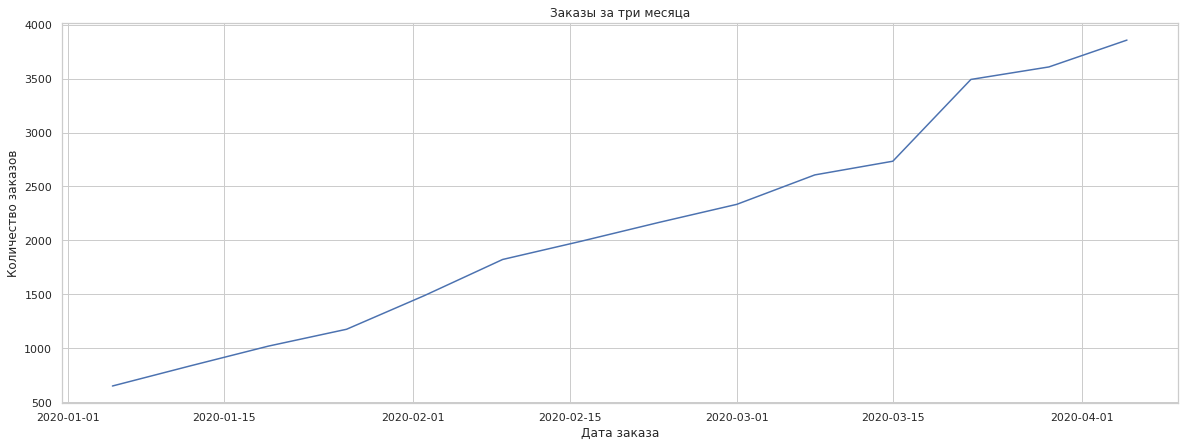

In [58]:
sns.set(style='whitegrid', rc={'figure.figsize': (20, 7)})
ax = sns.lineplot(x='date', y='orders_quantity', data=df2)
ax.set_xlabel('Дата заказа')  
ax.set_ylabel('Количество заказов')  
ax.set_title('Заказы за три месяца')  

Для того, чтобы посчитать линейную корреляцию, заменим дату на номер недели.

In [59]:
prediction = df2.reset_index().rename(columns={'index': 'week_number'}).drop('date', axis=1)

In [60]:
prediction.head()

,week_number,orders_quantity
0,0,650
1,1,837
2,2,1020
3,3,1176
4,4,1489


In [156]:
st.pearsonr(prediction.week_number, prediction.orders_quantity) 

(0.9912385193764021, 6.408985072063773e-12)

In [157]:
st.spearmanr(prediction.week_number, prediction.orders_quantity)

SpearmanrResult(correlation=1.0, pvalue=0.0)

In [158]:
st.kendalltau(prediction.week_number, prediction.orders_quantity) 

KendalltauResult(correlation=1.0, pvalue=2.294149119545945e-11)

Коэфициент корреляции равен единице, значит статистически значимо видно завсимость роста продаж со временем, мы видим положительную динамику

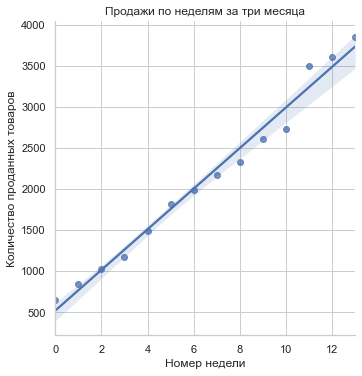

In [159]:
sns.set(style='whitegrid', rc={'figure.figsize': (20, 7)})
sns.lmplot(x='week_number', y='orders_quantity', data=prediction)
plt.title('Продажи по неделям за три месяца')
plt.xlabel('Номер недели')
plt.ylabel('Количество проданных товаров');

In [271]:
X1 = sm.add_constant(prediction.week_number)  # добавить константу, чтобы был свободный член
model = sm.OLS(prediction.orders_quantity, X1)  # говорим модели, что у нас ЗП, а что НП
results1 = model.fit()  # строим регрессионную прямую
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:        orders_quantity   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     675.8
Date:                Thu, 30 Sep 2021   Prob (F-statistic):           6.41e-12
Time:                        18:21:59   Log-Likelihood:                -88.326
No. Observations:                  14   AIC:                             180.7
Df Residuals:                      12   BIC:                             181.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         518.5143     72.825      7.120      

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [61]:
b0 = 518.5143
b1 = 247.5253

Формула регрессионной прямой:
b0 + b1*х, где х в нашем случае - это номер недели

Добавим в таблицу столбец со значениями получившейся линейной регрессии

In [62]:
prediction['model'] = round(b0 + b1 * prediction.week_number)

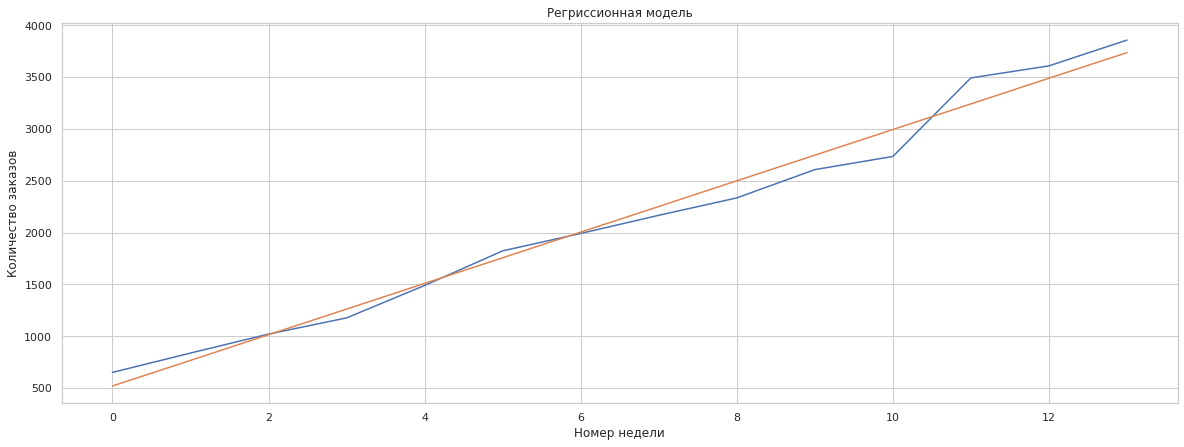

In [63]:
ax2 = sns.lineplot(x='week_number', y='orders_quantity', data=prediction)
ax2 = sns.lineplot(x='week_number', y='model', data=prediction)
ax2.set_xlabel('Номер недели')  
ax2.set_ylabel('Количество заказов')  
ax2.set_title('Регриссионная модель') ;

На основе построенной модели, рассчитаем прогноз ещё на 14 недель вперёд

In [64]:
y = 0
for i in range(14, 27):
    y = round(b0 + b1 * i)
    prediction = prediction.append({'week_number': i, 'model': y}, ignore_index=True)

Теперь вместо номера недель поставим даты

In [65]:
prediction['week_number'] = pd.date_range(start='2020-01-05', end='2020-07-05', freq='W')

In [66]:
prediction = prediction.rename(columns={'week_number': 'date'})

In [67]:
prediction.head()

,date,orders_quantity,model
0,2020-01-05,650.0,519.0
1,2020-01-12,837.0,766.0
2,2020-01-19,1020.0,1014.0
3,2020-01-26,1176.0,1261.0
4,2020-02-02,1489.0,1509.0


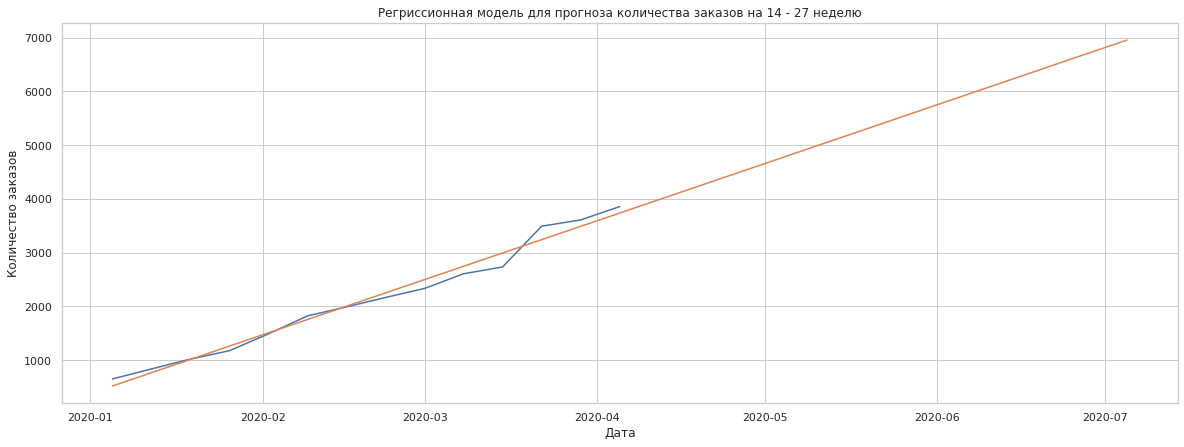

In [68]:
ax2 = sns.lineplot(x='date', y='orders_quantity', data=prediction)
ax2 = sns.lineplot(x='date', y='model', data = prediction)
ax2.set_xlabel('Дата')  
ax2.set_ylabel('Количество заказов')  
ax2.set_title('Регриссионная модель для прогноза количества заказов на 14 - 27 неделю') ;

### Задание 3.

Работа с базой данных.

Нужно написать запрос, чтобы получить такую таблицу
  - purchase_date – дата покупки
  - purchase_id – id покупки
  - client_id – id покупателя
  - client_age – возраст покупателя
  - client_registration_age – как долго человек пользуется вашими магазинами
  - client_category – содержит new или old, если это первая или последующая покупка соответственно
  - promotion_name – акция
  - category_name – категория
  - partner_name – партнёр
  - client_city – город, где находится покупатель
  - city – город
  - revenue – сумма выручки
  - quantity – число проданных единиц

При этом в таблице должны присутствовать только значения, где в поле status стоит значение 1, и только те, где purchase_date находится в диапазоне от 01.05.2020 до 01.08.2020

   База данных доступна по имени project_variant_2  

In [1]:
import pandahouse as ph

In [2]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database': 'default',
                      'user': 'student', 
                      'password': 'dpo_python_2020'}

In [3]:
q = '''
SELECT 
    PU.purchase_date AS purchase_date,
    PU.purchase_id AS purchase_id,
    PU.client_id AS client_id,
    DATEDIFF(year, CL.birth_date, PU.purchase_date) AS client_age,
    DATEDIFF(day, CL.registration, PU.purchase_date) AS client_registration_age,
     CASE 
            WHEN  PU.purchase_id = FP.first_purchase
                THEN 'new'
                ELSE 'old'
            END as client_category,
    PR.promotion_name AS promotion_name,
    PR.category_name AS category_name,
    PR.partner_name AS partner_name,
    CI.client_city AS client_city,
    CI.city AS city,
    toFloat32(PU.price) * toFloat32(PU.quantity) AS revenue,
    toFloat32(PU.quantity) AS quantity
FROM project_variant_2.purchase AS PU
LEFT JOIN project_variant_2.promotion AS PR
ON PU.promotion_id = PR.promotion_id AND PU.partner_id = PR.partner_id AND PU.category_id = PR.category_id 
LEFT JOIN project_variant_2.client AS CL
ON PU.client_id = CL.client_id 
LEFT JOIN project_variant_2.city AS CI
ON PU.city_id = CI.city_id AND CL.client_city_id = CI.client_city_id 
LEFT JOIN 
    (SELECT client_id,
    MIN(purchase_id) as first_purchase
    FROM project_variant_2.purchase
    WHERE status = 1
    GROUP BY client_id) AS FP
ON PU.client_id = FP.client_id
WHERE PU.status = 1 AND '2020-05-01' <= PU.purchase_date AND 
           PU.purchase_date <= '2020-08-01'
'''

In [4]:
df3 = ph.read_clickhouse(query=q, connection=connection_default)

In [5]:
df3.head(10)

,purchase_date,purchase_id,client_id,client_age,client_registration_age,client_category,promotion_name,category_name,partner_name,client_city,city,revenue,quantity
0,2020-06-05,0,853,28,364,new,,,,Ярославль,Киев,150.0,5.0
1,2020-06-15,1,406,23,249,new,,,,Минск,Новгород,1150.0,5.0
2,2020-08-01,9,867,24,59,new,,,,Киев,Москва,1840.0,4.0
3,2020-07-16,15,109,29,606,new,,,,Щучинщина,Санкт-Петербург,440.0,8.0
4,2020-06-29,22,528,20,89,new,,,,,,390.0,2.0
5,2020-05-18,26,10,20,192,new,campaign_4,Прочее,KarpovCourses,Ярославль,Санкт-Петербург,570.0,2.0
6,2020-07-07,27,366,26,342,new,,,,Казань,Казань,880.0,4.0
7,2020-07-08,33,77,23,180,new,,,,Вена,Минск,555.0,3.0
8,2020-05-29,38,46,30,489,new,,,,Москва,Москва,2820.0,6.0
9,2020-06-07,39,211,29,513,new,,,,,,170.0,1.0


Посмотрим основную информацию о получившейся таблице

In [6]:
df3.shape

(2735, 13)

In [7]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2735 entries, 0 to 2734
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   purchase_date            2735 non-null   datetime64[ns]
 1   purchase_id              2735 non-null   int32         
 2   client_id                2735 non-null   int32         
 3   client_age               2735 non-null   int64         
 4   client_registration_age  2735 non-null   int64         
 5   client_category          2735 non-null   object        
 6   promotion_name           2735 non-null   object        
 7   category_name            2735 non-null   object        
 8   partner_name             2735 non-null   object        
 9   client_city              2735 non-null   object        
 10  city                     2735 non-null   object        
 11  revenue                  2735 non-null   float64       
 12  quantity                 2735 non-

Для примера посмотрим данные из таблицы для одного из клиентов

In [8]:
df3.query('client_id == 853')

,purchase_date,purchase_id,client_id,client_age,client_registration_age,client_category,promotion_name,category_name,partner_name,client_city,city,revenue,quantity
0,2020-06-05,0,853,28,364,new,,,,Ярославль,Киев,150.0,5.0
218,2020-06-03,721,853,28,362,old,,,,Ярославль,Минск,200.0,5.0
683,2020-06-15,2154,853,28,374,old,,,,Ярославль,Ярославль,455.0,7.0
954,2020-06-29,2930,853,28,388,old,,,,Ярославль,Москва,225.0,9.0
1983,2020-06-01,6027,853,28,360,old,,,,Ярославль,Казань,2280.0,6.0
2254,2020-06-12,6820,853,28,371,old,,,,Ярославль,Ярославль,630.0,9.0


Посмотрим данные о клиентах 

In [9]:
df3.groupby('client_age', as_index=False)\
    .agg({'client_id': 'nunique', 'revenue': 'sum'})\
    .rename(columns={'client_id': 'clients_quantity'})\
    .sort_values('revenue')

,client_age,clients_quantity,revenue
10,30,17,77100.0
1,21,67,266880.0
3,23,82,290195.0
7,27,72,298155.0
6,26,80,316225.0
2,22,81,318740.0
9,29,83,325890.0
0,20,67,331895.0
4,24,87,357570.0
8,28,82,358215.0


Видим, что клиенты возраста от 20 до 30 лет, больше всего прибыли приносят клиенты 25 лет

In [10]:
df3.groupby('client_id', as_index=False)\
    .agg({'purchase_id': 'nunique', 'revenue': 'sum', 'client_age': 'unique', 'client_city': 'unique'})\
    .sort_values('purchase_id', ascending=False).head(10)

,client_id,purchase_id,revenue,client_age,client_city
143,171,10,10820.0,[27],[Вена]
510,625,9,9840.0,[20],[Санкт-Петербург]
84,101,9,10695.0,[26],[Щучинщина]
485,597,9,12735.0,[29],[Ярославль]
136,163,9,15030.0,[24],[Вена]
236,282,8,4010.0,[26],[Ярославль]
655,802,8,10070.0,[28],[Новгород]
687,846,8,13015.0,[29],[Киев]
375,455,8,7565.0,[25],[Вена]
734,906,8,8145.0,[24],[Москва]


Больше всего покупок сделал клиент с id 171, 27-ми лет из Вены, на сумму 10820.0

In [11]:
df3.groupby('client_city', as_index=False)\
    .agg({'client_id': 'nunique'})\
    .rename(columns={'client_id': 'clients_quantity'})\
    .sort_values('clients_quantity', ascending=False).head(10)

,client_city,clients_quantity
0,,104
5,Москва,100
7,Санкт-Петербург,98
3,Киев,93
6,Новгород,88
1,Вена,87
8,Щучинщина,85
2,Казань,82
9,Ярославль,82
4,Минск,81


Больше всего клиентов из Москвы и Санкт-Петербурга